<h1><center><br/>Study of Celestial Object</center></h1>

<center><img src="http://drive.google.com/uc?export=view&id=1KXvgEdXdJ2uxEXukaH5RoDTEPDX9iHak" style="height: 600px;"/></center>

<h3><center><i>Jason Stock</i> <br/><br/>
    <i>Colorado State University</i></center></h3>

--- 

# Table of Contents
* [Introduction](#Introduction)
* [Data Exploration](#Data-Exploration)
* [Neural Networks](#Neural-Networks)
  * [Scaled Conjugate Gradient](#Scaled-Conjugate-Gradient)
  * [PyTorch](#PyTorch)
* [Conclusion](#Conclusion)

# Introduction

Looking up on a starlight night and pondering the abyss of uncertainty is not of recent discussion, and the questions that unfold are ones that have circulated throughout many cultures and society. The scientific community and researchers alike have done great work to better understand and collect information about the universe. An example of many is seen with the Sloan Digital Sky Survey (SDSS) - a major multi-spectral imaging and spectroscopic redshift survey that is mapping the night sky. A project that includes collecting relative coordinates, absolute brightness, redshift, magnitude, and more on celestial objects.  

...

# Data Exploration

There are various dependencies for use of this notebook labeled in the import section below.  Additionally, the SDSS data needs to be downloaded and imported to the current working directory.  For this, data was directly queried via the SDSS Database Server with the following SQL query:

~~~ sql
-- This query does a table JOIN between the imaging (PhotoObj) and spectra
-- (SpecObj) tables and includes the necessary columns in the SELECT to upload
-- the results to the SAS (Science Archive Server) for FITS file retrieval.
SELECT TOP 500000
   p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
   p.run, p.rerun, p.camcol, p.field,
   s.specobjid, s.class, s.z as redshift,
   s.plate, s.mjd, s.fiberid
FROM PhotoObj AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE 
   p.u BETWEEN 0 AND 19.6
   AND g BETWEEN 0 AND 20
~~~

The response is formatted to a CSV file named SkyData.csv for ease of use.  In Python, Pandas `read_csv` function helps contain the data in a DataFrame.

In [3]:
import matplotlib.pylab as plt
import mlutils as ml
import neuralnetworks as nn
import numpy as np 
import pandas as pd
import random
import seaborn as sns
import scipy.constants 
import time
import torch
import torch.nn
import torch.utils.data

from matplotlib.pyplot import cm
from ipywidgets import FloatProgress
from IPython.display import display
from pprint import pprint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
data = pd.read_csv('SkyData.csv', sep=',', low_memory=False)

In [5]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648721767104684,178.916132,0.369850,19.18494,17.28407,16.41079,16.00360,15.70586,756,301,4,421,320977438219724800,GALAXY,0.065127,285,51930,349
1,1237648721768022143,180.962195,0.342646,17.52684,15.85701,15.21702,14.96524,14.85095,756,301,4,435,3256236472499464192,STAR,-0.000156,2892,54552,487
2,1237648721768022137,180.959776,0.416301,17.77226,16.47326,15.96202,15.75909,15.66772,756,301,4,435,3256234823232022528,STAR,0.000388,2892,54552,481
3,1237648721768022132,180.953075,0.307552,19.01313,17.71921,17.16157,16.92821,16.82746,756,301,4,435,3284392491452753920,STAR,0.000469,2917,54556,518
4,1237648721768022028,180.899848,0.417192,18.12065,17.09130,16.80376,16.70857,16.69069,756,301,4,435,3256231249819232256,STAR,0.000050,2892,54552,468


Rather than looking at all 500,000 samples of data, the first five displayed are used to give a good indication of the columns.  The data is packed with information from imagery and spectra data to coordinate approximations.  These can be defined as:  

* **objid**: Unique object ID
* **ra**: Right ascension, $\mu$ [hours, minutes, and seconds]
* **dec**: Declination, $\nu$ [degrees, arcminutes, and arcseconds]  

Right ascension refers to the angular distance of a particular point measured eastward along the celestial equator from the Sun on the vernal equinox to the point above the earth in question.  Declination is the angular distance of an object on the celestial sphere in the equatorial coordinate system.  Together, these orthogonal coordinates can be used to describe a position similar to latitude and longitude, but extending into space.  It is so that any particular object has the same celestial coordinates for all observers on Earth.

* **u**: Ultraviolet, $\Delta \lambda = 3543 Å$
* **g**: Green, $\Delta \lambda = 4770 Å$
* **r**: Red, $\Delta \lambda = 6231 Å$
* **i**: Near Infrared, $\Delta \lambda = 7625 Å$
* **z**: Infrared, $\Delta \lambda = 9134 Å$

Color of an object is defined by the difference in magnitude between electromagnetic spectra.  Astronomical magnitude refers to the brightness of a stellar object, such that the higher numbers correspond to fainter objects, and lower numbers to those that are brighter.  These magnitudes correspond to specific bands of light following he Gunn-Thuan griz system that was employed by the SDSS.  Thus, telescopes use filters to capture light in  green ($g$), red ($r$), and those not on the visible spectrum; ultraviolet ($u$), and two infrared wavelengths ($i$ and $z$) in units of [Angstroms][1].  

The wavelength(s) for some object can give indication to what is the composition, temperature, color for that source, and more.  The color index for some object is calculated by taking the difference of magnitude in the various filters, e.g., a star with a high $g-r$ value will appear more red then than one with a low $g-r$ value, and thus allowing the effective temperature to be determined.  A popular application of calculating magnitude differences is to display color-color graphs to target outliers of the main-sequence in the data.  This technique has been used to identify ultra-cool subdwarfs, binary stars, quasars, etc.

It is evident that all objects radiate energy at various wavelengths and the plethora of stars, galaxies, and quasars may differentiate on this spectrum.

* **run**:  Run number
* **rerun**: Rerun number
* **camcol**: Camera column
* **field**: Field number  

These four features are tied together; such that the run number is used to identify a specific scan where the camcol identifies the scanline within a run (typically a number between 1-6), and each camcol is artificially broken down up into a series of overlapping fields that consists of the frames of the $u, g, r, i, z$ filters for the same region in the sky [2].

* **specobjid**: Unique ID for optical spectroscopic objects
* **class**:  Photometric classification

The specobjid encodes information about the plate, mjd, and fiberid for spectroscopic objects.  A more important identifier is the classification that is used to assign a *type* (star, galaxy, or quasar) to each object.  The class will be of importance as this notebook will discover a variety of features to classify spectral objects.

* **redshift**: Photometric redshift  

The various types of electromagnetic waves (ultraviolet, infrared, visible light, etc) differ only in variations in wavelength and frequency defined by the equation $c = \lambda f$ : $c$ is the speed of light in a vacuum.  The speed of light can be derived by Maxwell's Equations, and specifically by the wave equations for electromagnetic waves where the equation for electric field defines the permittivity of free space, $\varepsilon_0$, and the equation for magnetic field defines the permeability of free space, $\mu_0$.  These two values are constants specified by a medium.  Thus, relating the perpendicular fields to the equation: $c = 1/\sqrt{\mu_0\varepsilon_0}$, displaying $c$ as a fundamental constant in a vacuum.  This shows the original proposition of electromagnetic waves differing only by their wavelength and frequency.

Redshift is defined when light is shifted towards the red end of the spectrum, i.e., towards lower frequencies.  This occurs when relative objects travel away from an observer, stretching the light, and thus have a higher redshift value.  This relates to the equation $c = \lambda f$, such that there is a relative-velocity phenomenon that induces a shift in frequency of electromagnetic waves between a source and an observer.  This is further defined as the Relativistic Doppler Effect [4].  

This is of importance since the expansion of the universe show objects traveling away from Earth.  The redshift magnitude relationship can then be used to describe various objects and photometric classes, i.e., stars galaxies, and quasars.  

* **plate**: Plate number
* **mjd**: Modified Julian Date
* **fiberid**:  Fiber ID

The SDSS spectrograph uses optical fibers to direct light at the focal plane from individual objects to the slithead.  For each exposure objects are assigned corresponding fiber ID's. A unique plate is set to position the optical fibers that feed into the spectrographs.  Once an image or spectrum is taken, a date and time is recorded [3].  

Collectively, the sample data from SDSS provides details for 500,000 objects of the class GALAXY, STAR, and QSO.  Each sample of data alludes to the imagery calibration and object details in the form of coordinates and spectral type.

In [6]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 18 columns):
objid        500000 non-null int64
ra           500000 non-null float64
dec          500000 non-null float64
u            500000 non-null float64
g            500000 non-null float64
r            500000 non-null float64
i            500000 non-null float64
z            500000 non-null float64
run          500000 non-null int64
rerun        500000 non-null int64
camcol       500000 non-null int64
field        500000 non-null int64
specobjid    500000 non-null uint64
class        500000 non-null object
redshift     500000 non-null float64
plate        500000 non-null int64
mjd          500000 non-null int64
fiberid      500000 non-null int64
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 68.7+ MB


All of the columns are displayed showing the total number of non-null entries dtypes and the total memory usage.  Subsequently, there appear to be no missing values in the range of entries - which is great!  A summary of the data is described below; displaying descriptive statistics that summarize the central tendency, dispersion and shape of the data's distribution.  This will properly be displayed in sections below.

In [7]:
data.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.0,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.237659e+18,184.609047,26.701782,18.639578,17.404906,16.874612,16.573492,16.372911,3184.455678,301.0,3.493806,191.770658,2.287559e+18,0.169630,2031.677928,53509.282640,338.537562
std,4.751024e+12,69.826568,20.902576,0.832731,0.984441,1.129197,20.067479,28.356798,1106.188066,0.0,1.594195,143.174457,1.850047e+18,0.430658,1643.160742,1288.151219,205.138360
min,1.237646e+18,0.002795,-11.252825,6.752484,7.466997,8.449127,-9999.000000,-9999.000000,94.000000,301.0,1.000000,11.000000,2.994897e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237655e+18,146.387666,7.112737,18.218737,16.851960,16.194050,15.862168,15.619250,2326.000000,301.0,2.000000,85.000000,1.065249e+18,0.000045,946.000000,52522.000000,167.000000
50%,1.237661e+18,186.609345,28.720064,18.873825,17.521935,16.897870,16.599300,16.420760,3530.000000,301.0,4.000000,157.000000,1.866913e+18,0.051609,1658.000000,53173.000000,332.000000
75%,1.237663e+18,225.598357,43.643623,19.272270,18.053130,17.571010,17.317392,17.199280,3970.000000,301.0,5.000000,257.000000,2.690911e+18,0.097635,2390.000000,54437.000000,497.000000
max,1.237667e+18,359.998882,79.742295,19.600000,19.996050,33.209920,32.349170,30.846780,5080.000000,301.0,6.000000,986.000000,1.013665e+19,7.009400,9003.000000,57520.000000,1000.000000


While there appear to be no missing values or *null-values*, looking at the spectral types, $u,g,r,i,z$, indicate a value of -9999.00 place holding possible inconsistent entries.  To handle this, all values of -9999.00 are dropped from the dataset.  

It was decided that the dataset will be balanced to contain an equal number of samples for each class (GALAXY/STAR/QSO).  Reasoning for this was twofold, i.e., to get a more equal distribution and simplify the computation in the analysis below. It is understood that removing samples removes possible artifacts that are used in classification, in addition to the fact that there are significantly more stars in the observable universe than galaxies, and more galaxies than quasars.  However, nearly 52,000 samples for each class is quite manageable and diverse.

In [8]:
print(data['class'].value_counts(), '\n' + '-'*25)

data = data[(data != -9999.0).all(1)]
_, c = np.unique(data['class'], return_counts=True)

data = data.sort_values(by=['class'])[c[0] - c[1] : c[0] + c[1]*2] \
           .sample(frac=1).reset_index(drop=True)

print(data['class'].value_counts())

GALAXY    274517
STAR      173684
QSO        51799
Name: class, dtype: int64 
-------------------------
GALAXY    51799
QSO       51799
STAR      51799
Name: class, dtype: int64


Analyzing spectral types and redshift will offer a better indication to how these features contribute to the machine learning algorithms in the upcoming sections.  Features were divided to see individual results by class, and displayed using various libraries from Seaborn; a statistical visualization package wrapped around matplotlib.  

The Pearson's Correlation Coefficient heatmap shown below is a color encoded matrix showing correlation across the features.  The correlation coefficient justifies values between -1 and 1, where a value approaching 1 is positively or strongly correlated and value approaching -1 is negatively or weakly correlated.  The heatmap, while annotated, easily shows this for each class by showing positive correlated features with a dark value, and light for those with negative correlation.  

Each matrix is a symmetric matrix with trivial correlation on the diagonal - which can be focused to the lower-triangular portion of the matrix.  Looking at the spectral magnitudes show a positive correlation increasing with wavelength, i.e., the near infrared, $i$, and infrared, $z$, filters are more correlated than the green, $g$, and infrared, $z$, filters.  Not only do these wavelengths fall closer to one another on the electromagnetic spectrum, but the system response of the filters described by the sensitivity to different wavelengths show adjacent overlap [5]. This can be seen in the figure of normalized responses of the SDSS system band-passes.  

Having multiple features with strong positive correlation, and thus, multicollinear could possibly yield widely varying models, or unreliable results.  However, since there is a descending correlation with decrease in wavelength and unique features, all spectra information will be used.  Contrary to this, redshift is negatively correlated with each of the spectral magnitudes.  Most interestingly, the correlation between classes, i.e., stars, galaxies, and quasars, all vary with distinct coefficients.  This is a good indication that redshift may be beneficial to training predictive models.

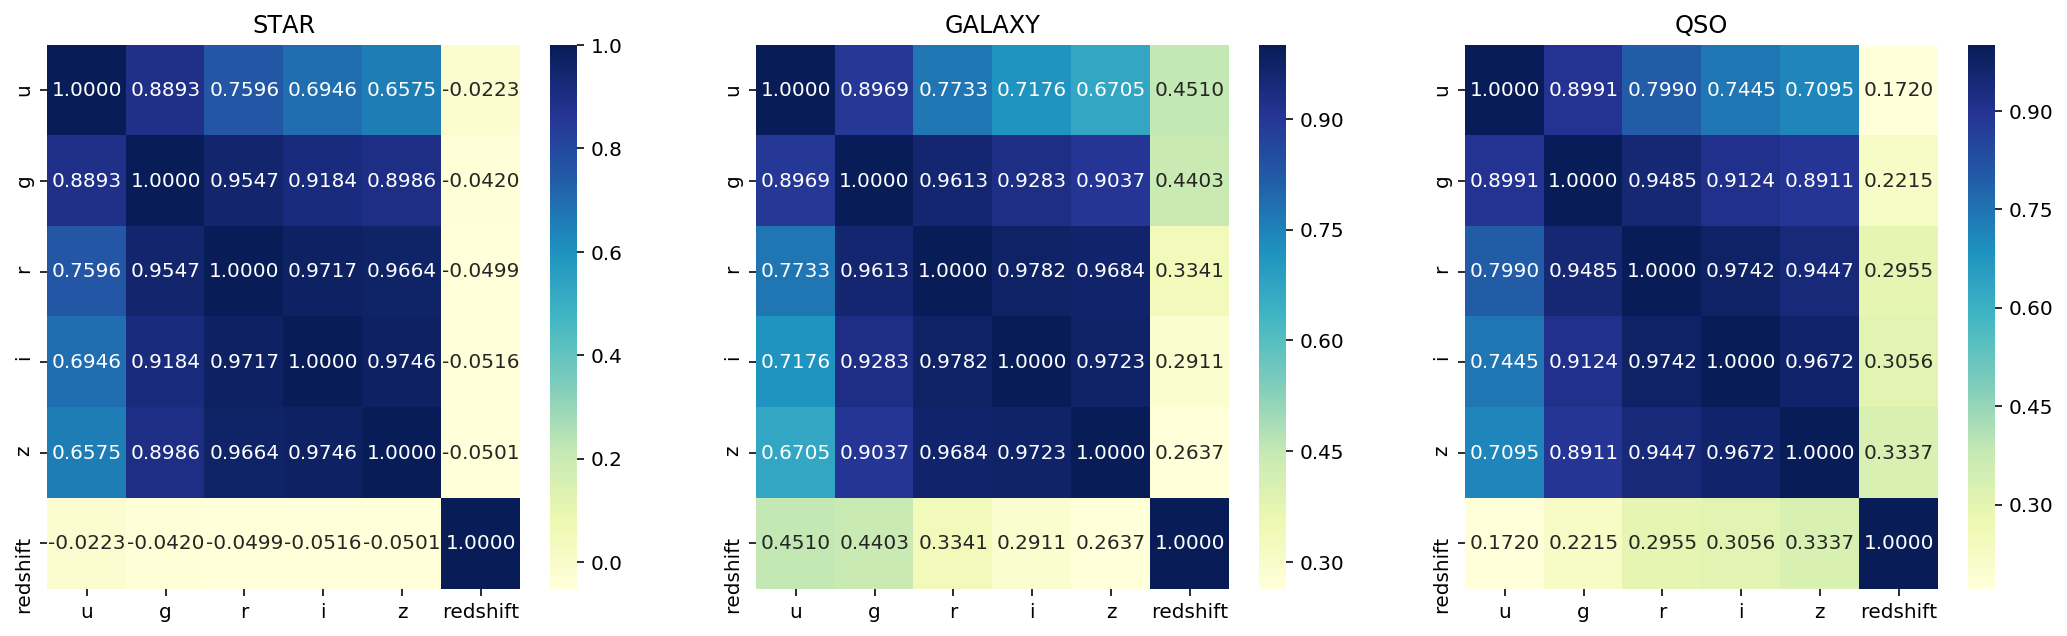

In [13]:
columns = ['u', 'g', 'r', 'i', 'z', 'redshift']

plt.figure(figsize=(18,5))
for i, v in enumerate(['STAR', 'GALAXY', 'QSO']):
    plt.subplot(1,3,i+1)
    corr = data[data['class'] == v][columns].corr(method='pearson')
    sns.heatmap(corr, annot=True, fmt='.4f', cmap='YlGnBu')
    plt.title(v)

plt.show()

<center><img src="http://drive.google.com/uc?export=view&id=1rjXRBcy9IBfTnKv5Mz1n_J-ACslIL1q3"/></center>
[6] Bessel, M.S. 2005, ARA&A, 43, 293

Descriptive statistics are projected to distribution and probability kernel density plots.  Placing these side by side, split by feature, is effective by showing a comparison across the various classes.  The six total features are plotted showing the mean, $\mu$, and standard deviation, $\sigma$, in the title across ever class.  Each violin plot shows a white dot for the mean value for that class.  Extending vertically are the quartiles of the distribution, some more narrow than others.  Horizontal width represents the density of samples across different values for that feature.  

Initial observations of the spectra information show quasars with higher mean values with narrow interquartile ranges (as indicated by the quartile ranges), and higher kernel density estimation frequencies.  This shows higher magnitudes specific to quasars repeatedly captured and not for others - a potential advantage for machine learning algorithms.  Stars and galaxies carry attributes that again differentiate one another that may be advantageous as well.  As for redshift, it is difficult to visualize the relationship for each summary via violin plots, so further visualizations will be explored.

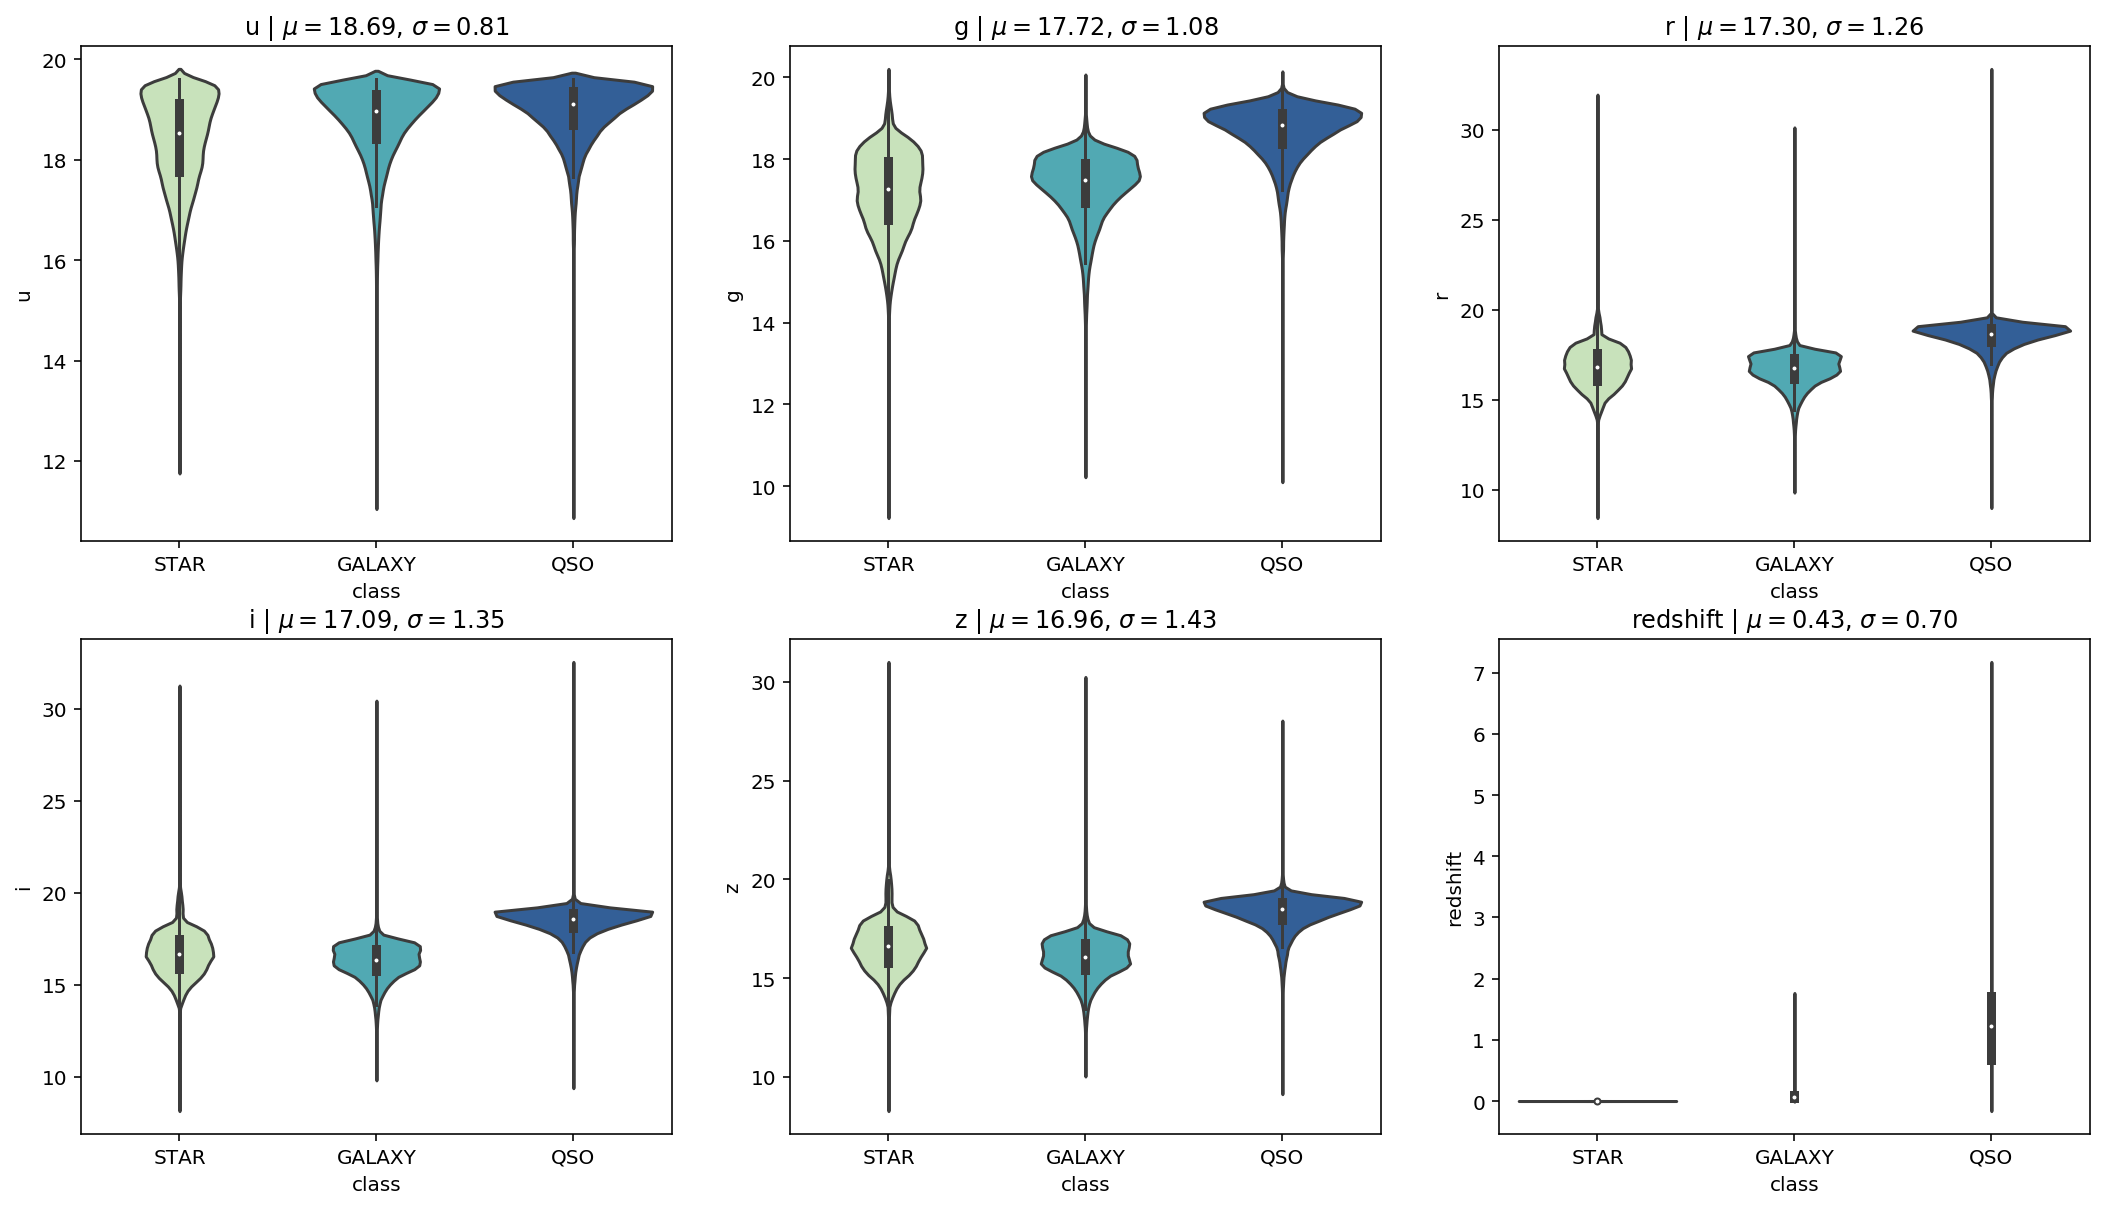

In [9]:
columns = ['u', 'g', 'r', 'i', 'z', 'redshift']

plt.figure(figsize=(18,10))

for i, v in enumerate(columns):
    plt.subplot(2,3,i+1)
    mu = np.mean(data[v])
    sigma = np.std(data[v])
    plt.title('{0} | $\mu={1:.2f}$, $\sigma={2:.2f}$'.format(v, mu, sigma))
    sns.violinplot(x='class', y=v, palette='YlGnBu', data=data);

plt.show()

...

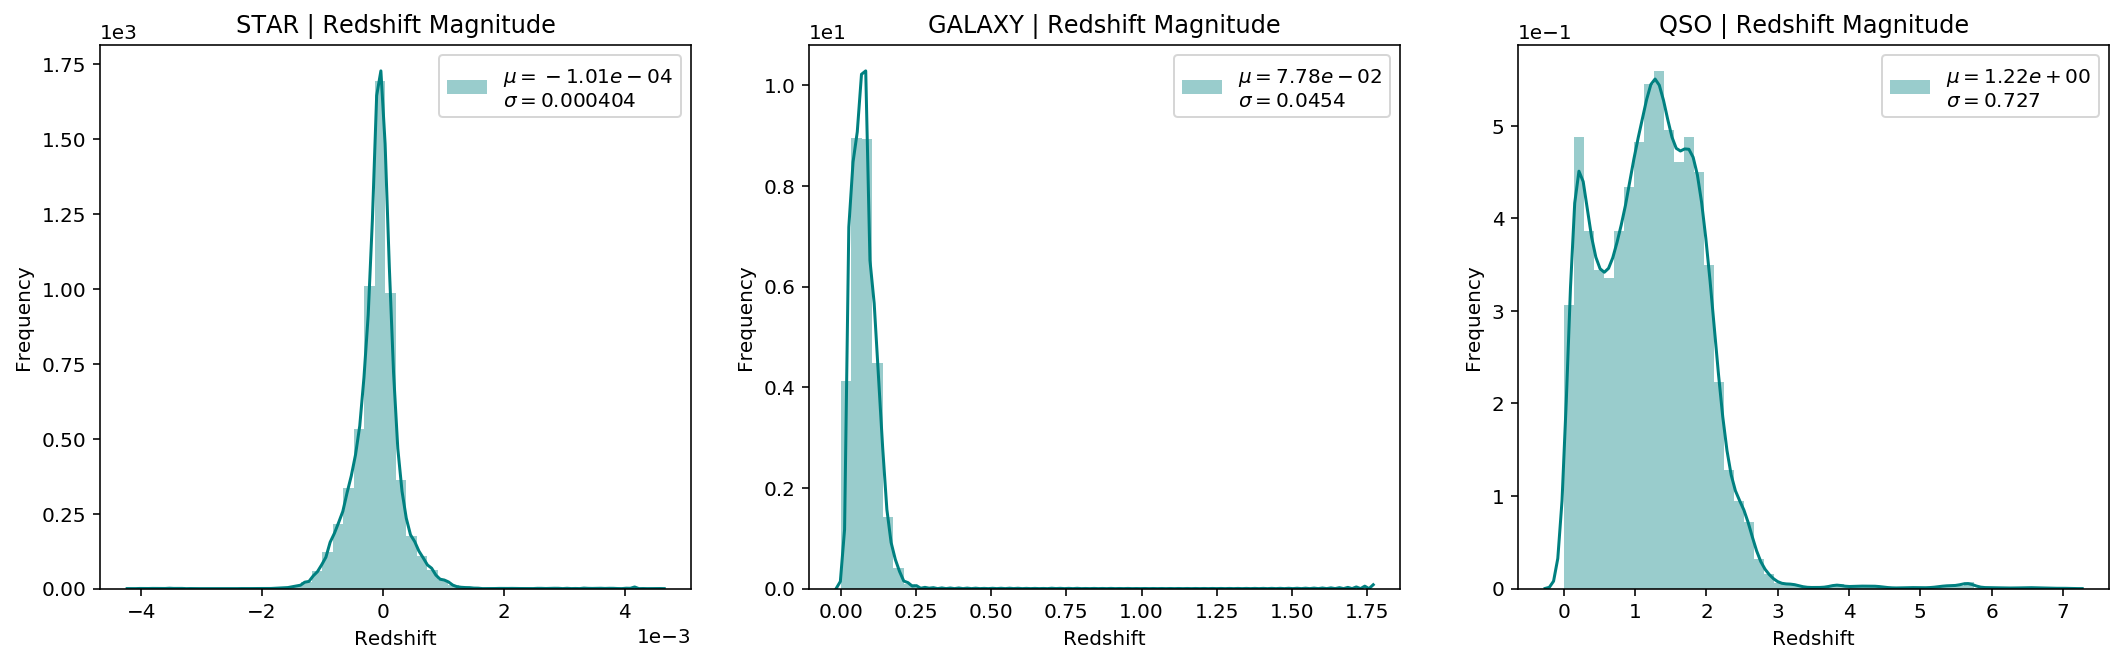

In [10]:
plt.figure(figsize=(18,5))

for i, v in enumerate(['STAR', 'GALAXY', 'QSO']):
    plt.subplot(1,3,i+1)
    x = np.array(data[data['class'] == v]['redshift'])
    
    mu = np.mean(x)
    sigma = np.std(x)
    
    sns.distplot(x, label='$\mu={0:10.2e}$\n$\sigma={1:.3}$'.format(mu, sigma), color='teal');
    plt.title('{} | Redshift Magnitude'.format(v))
    plt.xlabel('Redshift'), plt.ylabel('Frequency')
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,1))
    plt.legend()
    
plt.show()

...

In [10]:
print('The speed of light, c = {0} [km/sec]'.format(scipy.constants.c / 1000))
print('\nAverage Velocity [km/sec]:')
for i, v in enumerate(['STAR', 'GALAXY', 'QSO']):
    velocity = np.array(data[data['class'] == v]['redshift'] * (scipy.constants.c / 1000))
    print('{0:<6} | {1:.1f}'.format(v, np.mean(velocity)))

The speed of light, c = 299792.458 [km/sec]

Average Velocity [km/sec]:
STAR   | -30.2
GALAXY | 23309.4
QSO    | 366717.3


# Neural Networks

### Scaled Conjugate Gradient 

In [11]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations):
    train_p, test_p, timing = [], [], []
    f = FloatProgress(min=0, max=len(hiddenLayerStructures*numberRepetitions))
    display(f)
    for network in hiddenLayerStructures:
        l_train_p, l_test_p = [], []
        sT = time.time()
        for rep in range(0, numberRepetitions):
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1 - trainFraction), True)
            nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1], network, np.unique(T).shape[0])
            nnet.train(Xtrain, Ttrain, numberIterations)

            Ytrain = nnet.use(Xtrain)
            Ytest  = nnet.use(Xtest)

            l_train_p.append( np.sum(Ytrain!=Ttrain)/len(Ttrain) )
            l_test_p.append( np.sum(Ytest!=Ttest)/len(Ttest) )
            f.value += 1
            
        timing.append((time.time() - sT))
        train_p.append(l_train_p)
        test_p.append(l_test_p)
        
    return [ [hiddenLayerStructures[i], train_p[i], test_p[i], timing[i]]
                for i in range(0, len(hiddenLayerStructures)) ]

def summarize(results):
    for i in range(0, len(results)):
        results[i][1] = np.mean(results[i][1])
        results[i][2] = np.mean(results[i][2])
    
    return results

def bestNetwork(summary):
    min_index = np.argmin( [ [x[2]] for x in summary ] )
    return summary[min_index]

def printBest(best):
    print('\nBest:', best)
    print('\nHidden Layers {} Average Training {:.2f} Testing {:.2f} ' \
          'Took {:.4f} seconds'.format(*best))

In [12]:
def sampler(path, a, b):
    data = pd.read_csv(path, sep=',', low_memory=False)
    data = data[(data != -9999.0).all(1)]
    _, c = np.unique(data['class'], return_counts=True)

    data = data.sort_values(by=['class'])[c[0] - c[1] : c[0] + c[1]*2] \
           .sample(frac=1).reset_index(drop=True)


    X = data.iloc[:, np.r_[a]]
    T = [ [item] for item in np.unique(data.iloc[:, np.r_[b]], return_inverse=True)[1] ]
    
    return np.array(X), np.array(T), data

X, T, data = sampler('SkyData.csv', [3, 4, 5, 6, 7, 14], [13])

In [13]:
def print_classes():
    """Assignments of classes"""
    names = np.unique(data['class'])
    print('| ', end='')
    for i in range(0, len(np.unique(T))):
        print(i, '--', '{} | '.format(names[i]), end='')
print_classes()

| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

In [14]:
def get_values(X, T, network, itr, partition=False):
    if partition: 
        train_f = 0.8
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f), True)
        
        nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1], network, np.unique(T).shape[0]) 
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetworkClassifier(X.shape[1], network, np.unique(T).shape[0])
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace(), nnet

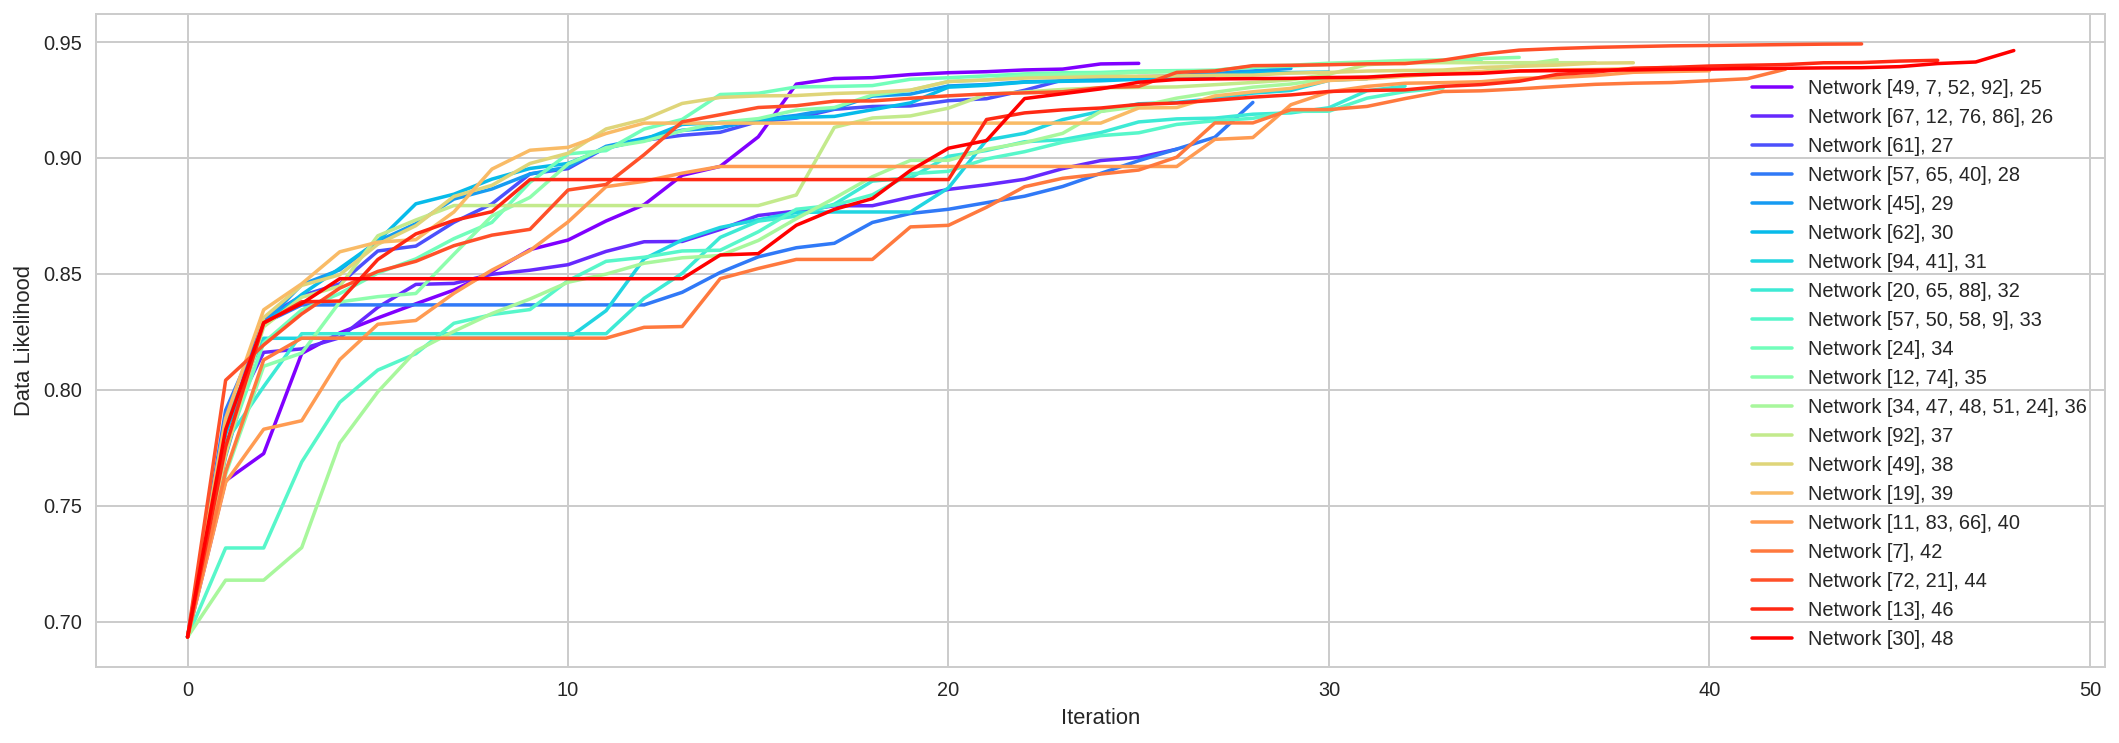

In [15]:
iters = 25
runs = 20
networks = []
it = []
er = []

f = FloatProgress(min=0, max=runs)
display(f)
for i in range(runs):
    a = random.sample(range(1, 100), np.random.randint(1, 6))
    Y, _T, error, _ = get_values(X, T, a, iters)
    networks.append(a)
    it.append(iters)
    er.append(error)
    iters = int(1.03 * iters)
    f.value += 1
    
plt.figure(figsize=(18,6))
sns.set_style("whitegrid")
color=iter(cm.rainbow(np.linspace(0,1,runs)))

for i, pl in enumerate(er):
    plt.plot(np.exp(-pl), c=next(color), label='Network '+str(networks[i])
                                               +', '+str(it[i]))

plt.title('Scaled Conjugate Gradient')
plt.xlabel('Iteration'), plt.ylabel('Data Likelihood')
plt.legend()
plt.show()

In [16]:
itr = 50
networks = 2
hidden = []
trainFraction = 0.80
numberRepetitions = 1

for i in range(networks):
    a = random.sample(range(1, 100), np.random.randint(1, 6))
    hidden.append(a)
    
results = trainNNs(X, T, trainFraction, hidden, numberRepetitions, itr)
summary = summarize(results)
best    = bestNetwork(summary)

pprint(summary)
printBest(best)

[[[27, 10], 0.041997474199023464, 0.042020592020592024, 8.240001201629639],
 [[53, 56, 71, 68, 45],
  0.047990218554180036,
  0.04732947232947233,
  84.12024545669556]]

Best: [[27, 10], 0.041997474199023464, 0.042020592020592024, 8.240001201629639]

Hidden Layers [27, 10] Average Training 0.04 Testing 0.04 Took 8.2400 seconds


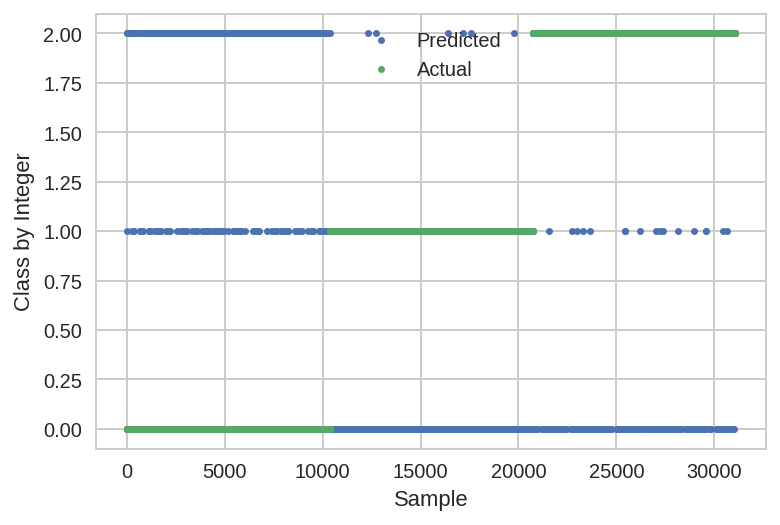

In [17]:
itr = 50
network = best[0]

Y, _T, error, nnet = get_values(X, T, network, itr, partition=True)

plt.plot(np.hstack((Y, _T)), '.')
plt.legend(['Predicted', 'Actual'])
plt.xlabel('Sample'), plt.ylabel('Class by Integer')
plt.show()

In [18]:
print('Incorrectly Predicted: %', (np.sum(Y!=_T)/len(_T)) * 100)
_ = ml.confusionMatrix(_T, Y, np.unique(_T))
print('-'*38)
print_classes()

Incorrectly Predicted: % 3.6743886743886747
       0    1    2
    ------------------
 0 | 96.0  0.8  3.2   (10360 / 10360)
 1 |  4.7 95.3  0.1   (10360 / 10360)
 2 |  2.1  0.2 97.7   (10360 / 10360)
--------------------------------------
| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

### PyTorch

In [207]:
def train_pytorch(X, T, learning_rate, iterations, optim, progress=True):
    
    class Net(torch.nn.Module):
        
        def __init__(self, n_in=X.shape[1], n_out=3):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_in, n_out, bias=True)
            self.output = torch.nn.LogSoftmax(dim=1)              

        def forward(self, X):
            out = self.hidden(X)
            out = self.output(out)
            return out
        
    f = FloatProgress(min=0, max=iterations)
    
    if progress:
        display(f)
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net().to(device)
    
    criterium = torch.nn.NLLLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    elif optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.90)
    
    tl = []
    for k in range(iterations):
        # Forward Pass
        pred = model(X)
        loss = criterium(pred, T.view(-1))

        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tl.append(loss.item())
        f.value += 1
        
    return model, np.array(tl)

In [208]:
X, T, data = sampler('SkyData.csv', [3, 4, 5, 6, 7, 14], [13])
trainFraction = 0.80

Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1 - trainFraction), True)

In [4]:
!nvidia-smi

Sun Nov 25 20:04:07 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   46C    P0    35W / 250W |      0MiB / 12066MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [209]:
Xtr = torch.Tensor(Xtrain)
Ttr = torch.Tensor(Ttrain).long()
Xtes = torch.Tensor(Xtest)
Ttes = torch.Tensor(Ttest).long()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on', str(device)+'...')

if torch.cuda.is_available():
    Xtr = Xtr.cuda()
    Ttr = Ttr.cuda()
    Xtes = Xtes.cuda()
    Ttes = Ttes.cuda()

Running on cuda...


In [210]:
def test_pytorch(optim, runs, iters, lr_bound):
    er = []
    info = []

    f = FloatProgress(min=0, max=runs)
    display(f)

    for i in range(runs):
        lr = np.random.randint(1, lr_bound) / 10000

        _, loss = train_pytorch(Xtr, Ttr, lr, iters, optim, False)
        er.append(loss)
        info.append((lr, iters))
        iters = int(1.03 * iters)
        f.value += 1

    plt.figure(figsize=(18,6))
    sns.set_style("whitegrid")
    color=iter(cm.rainbow(np.linspace(0,1,runs)))

    for i, pl in enumerate(er):
        plt.plot(np.exp(-pl), c=next(color), 
                 label='LR: {0:.3f} | I: {1} '.format(info[i][0], info[i][1]))

    plt.title(optim + ' | Learning Rate, Iterations')
    plt.xlabel('Iteration'), plt.ylabel('Data Likelihood')
    plt.legend(fontsize='medium')

    plt.show()
    return er, info

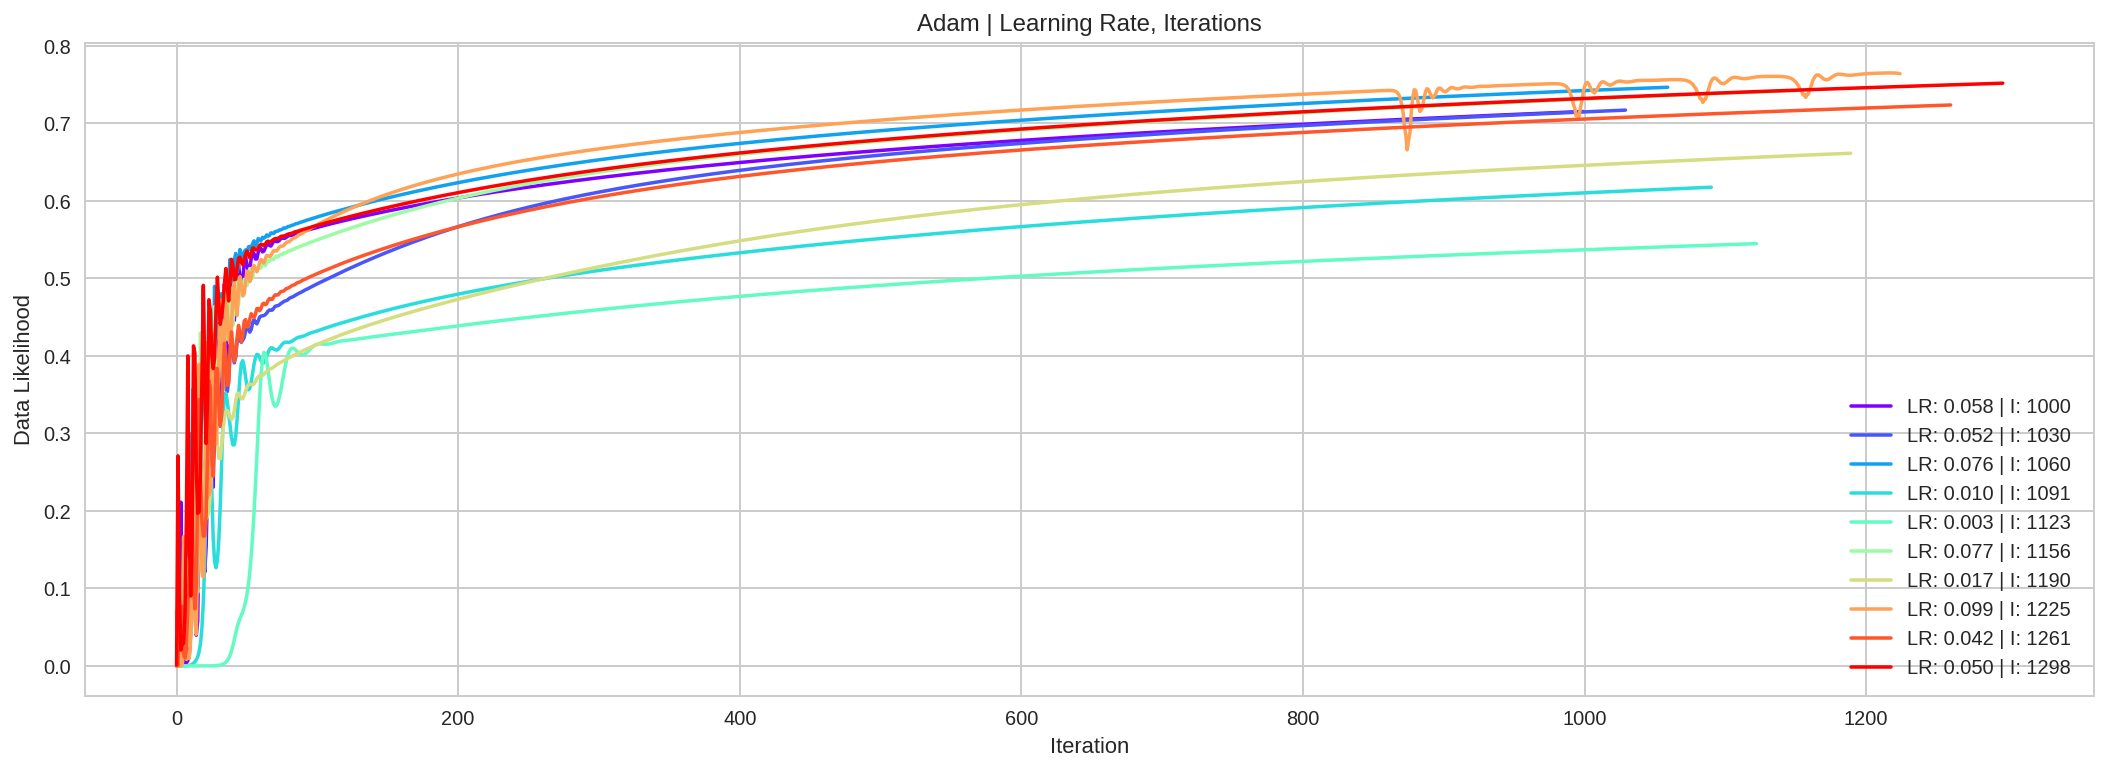

In [211]:
optim = 'Adam'
runs = 10
iters = 1000
lr_bound = 1000

er, info = test_pytorch(optim, runs, iters, lr_bound)

In [212]:
def get_model(optim, er, info, Xtr, Ttr):
    temp = []
    for i, li in enumerate(er):
        temp.append(np.min(li))
    i = np.argmin(temp)
    model, _ = train_pytorch(Xtr, Ttr, info[i][0], info[i][1], optim)
    return model

def use_pytorch(model, X, T):
    with torch.no_grad():
        output = model(X)
        _, Y = torch.max(output, 1)   # index of the class with maximum probability.
        Y = Y.cpu().numpy()
        if not isinstance(T, np.ndarray):
            T = T.cpu().numpy()
        T = np.concatenate(T).ravel()

    print('Incorrectly Predicted: %', (np.sum(Y!=T)/len(T)) * 100, '\n')
    _ = ml.confusionMatrix(T, Y, np.unique(T))
    print('-'*38)
    print_classes()

In [213]:
model = get_model(optim, er, info, Xtr, Ttr)
use_pytorch(model, Xtes, Ttes)

Incorrectly Predicted: % 8.172458172458171 

       0    1    2
    ------------------
 0 | 86.9  0.5 12.6   (10360 / 10360)
 1 |  6.7 93.2  0.1   (10360 / 10360)
 2 |  4.6  0.0 95.4   (10360 / 10360)
--------------------------------------
| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

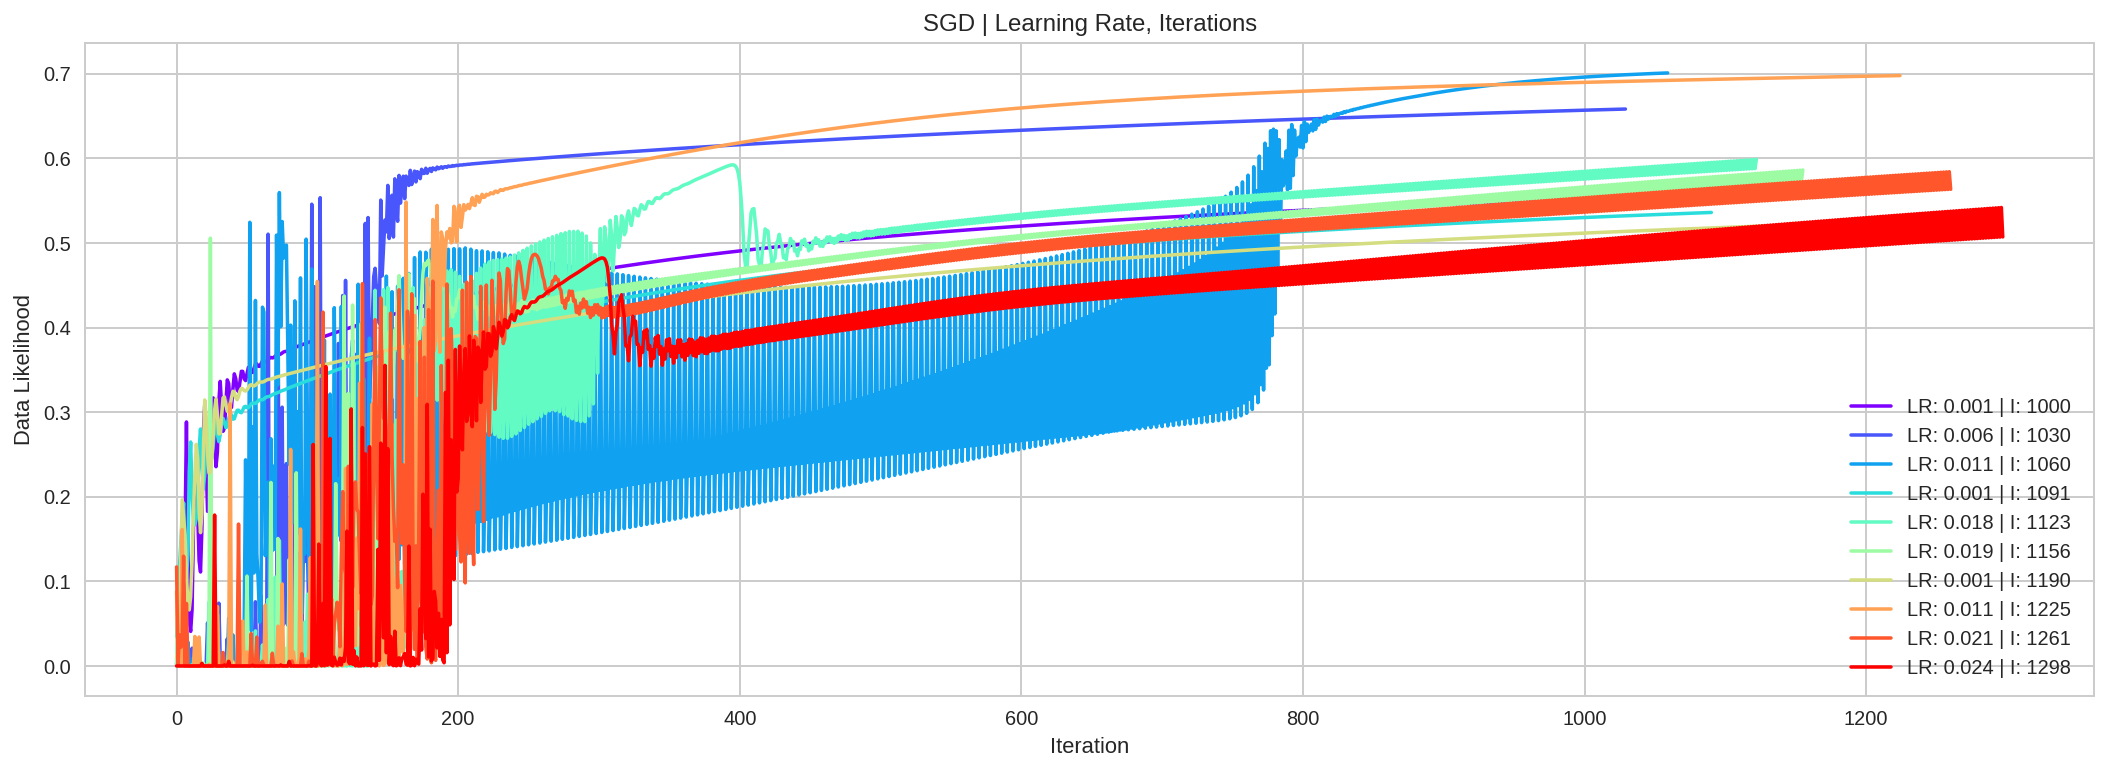

In [218]:
optim = 'SGD'
runs = 10
iters = 1000
lr_bound = 250

er, info = test_pytorch(optim, runs, iters, lr_bound)

In [219]:
model = get_model(optim, er, info, Xtr, Ttr)
use_pytorch(model, Xtes, Ttes)

Incorrectly Predicted: % 11.740669240669241 

       0    1    2
    ------------------
 0 | 81.9  0.3 17.8   (10360 / 10360)
 1 |  6.6 93.3  0.1   (10360 / 10360)
 2 | 10.2  0.2 89.6   (10360 / 10360)
--------------------------------------
| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

# Conclusion

# Resources

[1] https://www.astro.umd.edu/~ssm/ASTR620/mags.html  
[2] http://www.sdss3.org/dr10/imaging/imaging_basics.php  
[3] https://www.sdss.org/dr12/help/glossary/  
[4] Physics for Scientists and Engineers, Tipler  
[5] http://classic.sdss.org/dr7/instruments/imager/  
[6] Standard Photometric Systems, Michael S. Bessell, Annual Review of Astronomy and Astrophysics 2005 43:1, 293-336  
